In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams


In [2]:
df=pd.read_csv('/content/drive/My Drive/airline_passengers.csv')

In [3]:
df.columns=['date','passengers']

In [4]:
#dropping null values
df.dropna(inplace=True)

In [5]:
df['date']=pd.to_datetime(df['date'])

In [6]:
df.set_index('date',inplace=True)

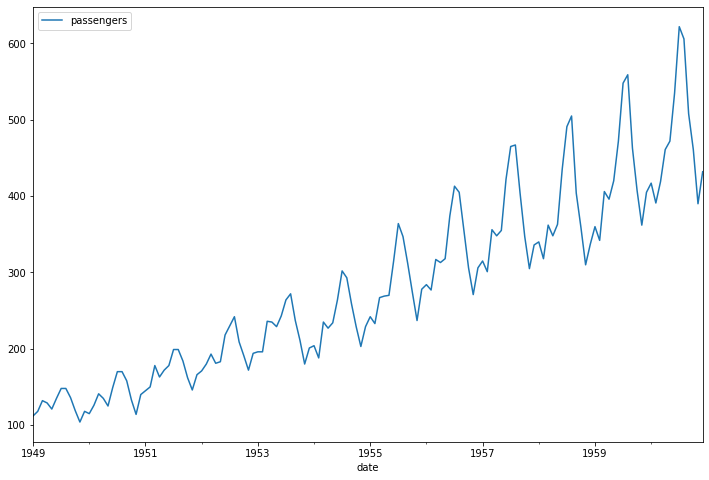

In [7]:
df.plot(figsize=(12,8))

In [8]:
decomposition=seasonal_decompose(df)
trend=decomposition.trend
seasonal=decomposition.seasonal
residual=decomposition.resid

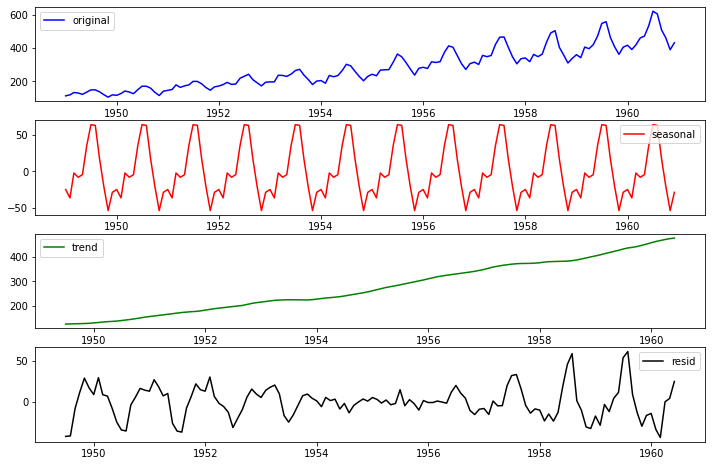

In [9]:
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(df,label='original',color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(seasonal,label='seasonal',color='red')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(trend,label='trend',color='green')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual,label='resid',color='black')
plt.legend(loc='best')

In [10]:
# Finding if data is seasonal

In [11]:
# rolling mean & std
roll_mean=df.rolling(window=8).mean()
roll_std=df.rolling(window=8).std()

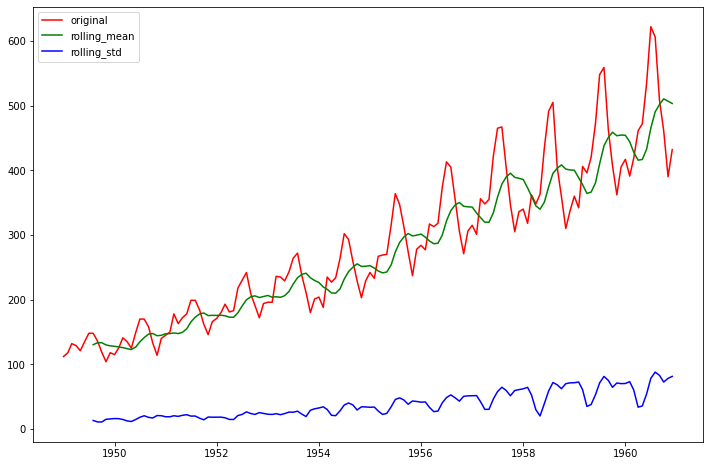

In [12]:
fig=plt.figure(figsize=(12,8))
plt.plot(df,color='red',label='original')
plt.plot(roll_mean,color='green',label='rolling_mean')
plt.plot(roll_std,color='blue',label='rolling_std')
plt.legend(loc='best')
plt.show()

In [13]:
# dickeyfuller test
dftest=adfuller(df['passengers'])
dfoutput=pd.Series(dftest[0:4],index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dftest)

print ('Results of Dickey-Fuller test: \n')

print(dfoutput)



(0.815368879206047, 0.991880243437641, 13, 130, {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}, 996.6929308390189)
Results of Dickey-Fuller test: 

Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [14]:
# function to chect stationary

def stationarity_check(TS):
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=8, center=False).mean()
    roll_std = TS.rolling(window=8, center=False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller(TS['passengers'])
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    plt.plot(TS, color='blue',label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None


In [15]:
# lets make the data stationary

In [16]:
# log transformation
log_df=np.log(df)

In [17]:
# Calculate Weighted Moving Average of log transformed data
exp_roll_mean=log_df.ewm(halflife=4).mean()

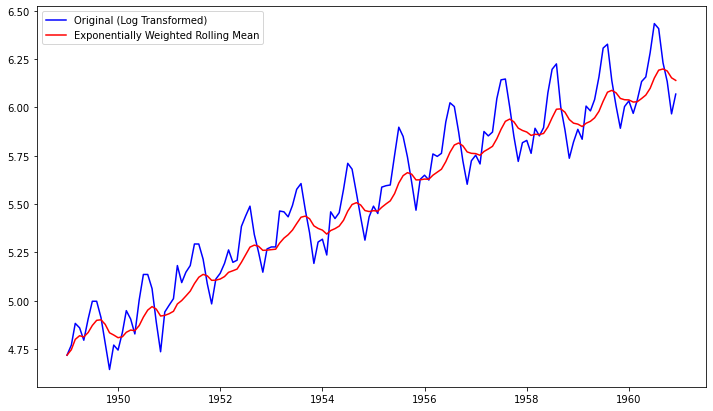

In [18]:
# Plot the original data with exp weighted average
fig = plt.figure(figsize=(12,7))
plt.plot(np.log(df), color='blue',label='Original (Log Transformed)')
plt.plot(exp_roll_mean, color='red', label='Exponentially Weighted Rolling Mean')
plt.legend(loc='best')
plt.show(block=False)

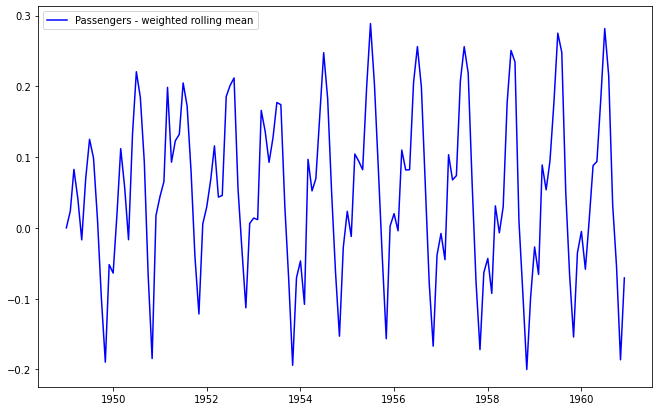

In [19]:
# substracting ewm from log data
data_minus_exp_roll_mean = np.log(df) - exp_roll_mean
# Plot the time series
fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_exp_roll_mean, color='blue',label='Passengers - weighted rolling mean')
plt.legend(loc='best')
plt.show(block=False)

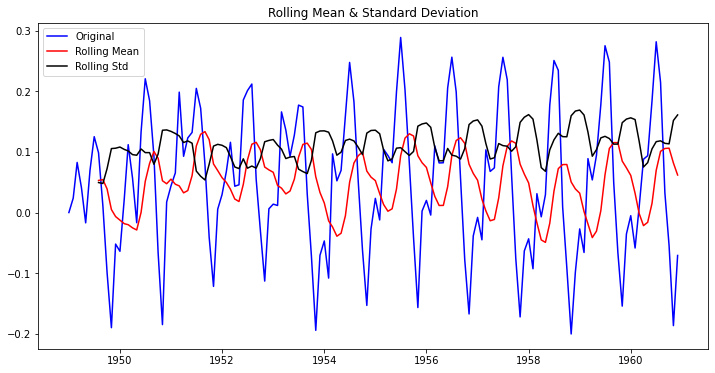

Results of Dickey-Fuller Test: 

Test Statistic                  -3.297250
p-value                          0.015002
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [20]:
stationarity_check(data_minus_exp_roll_mean)

In [21]:
# differencing
data_diff=data_minus_exp_roll_mean.diff(periods=12)
data_diff.dropna(inplace=True)

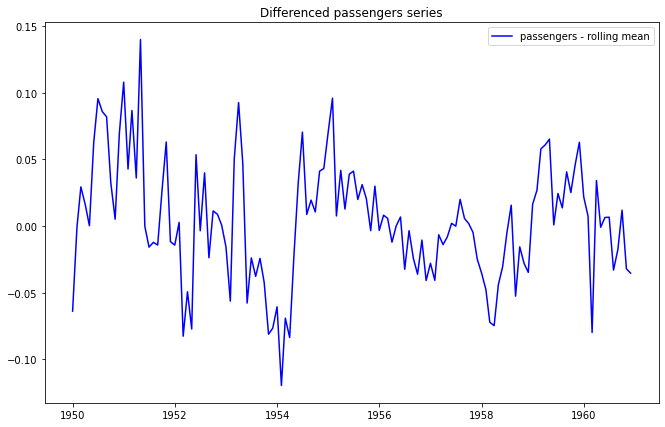

In [22]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_diff, color='blue',label='passengers - rolling mean')
plt.legend(loc='best')
plt.title('Differenced passengers series')
plt.show(block=False)


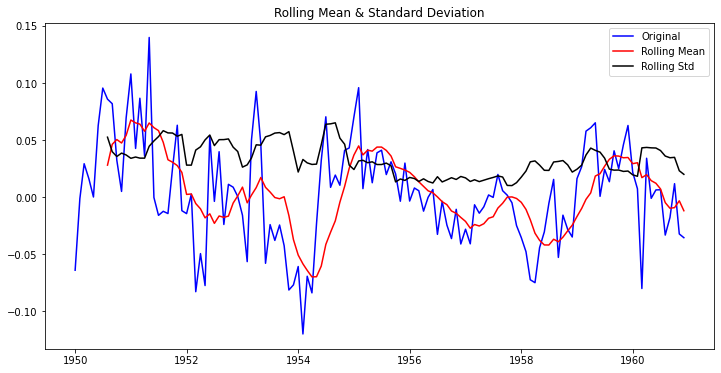

Results of Dickey-Fuller Test: 

Test Statistic                  -3.601666
p-value                          0.005729
#Lags Used                      12.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [23]:
stationarity_check(data_diff)

In [24]:
# ACF & Pacf

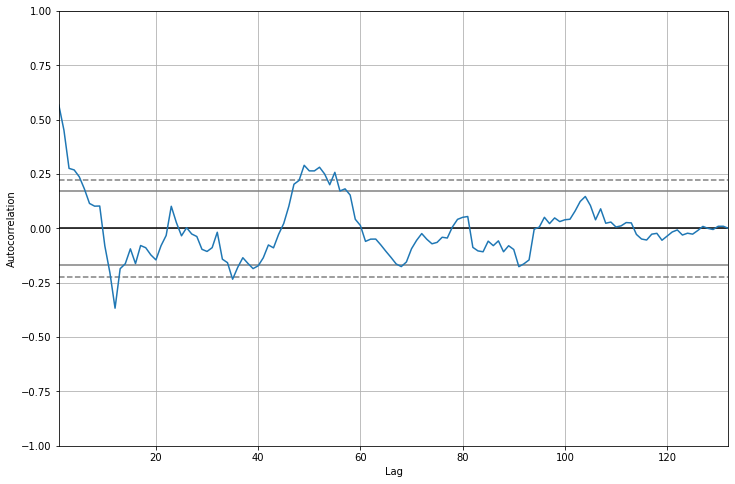

In [25]:
plt.figure(figsize=(12,8))
pd.plotting.autocorrelation_plot(data_diff)

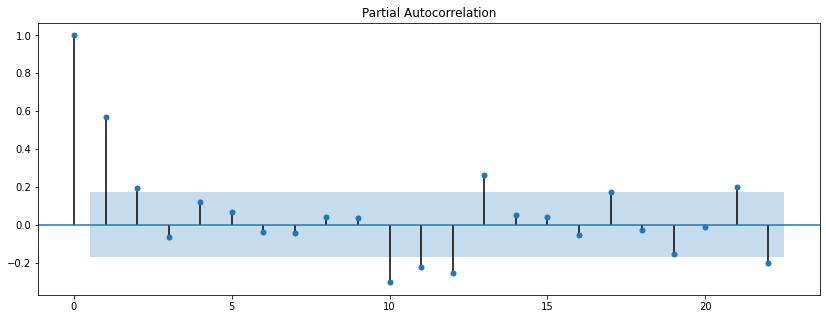

In [26]:
rcParams['figure.figsize'] = 14, 5
plot_pacf(data_diff);